In [ ]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [74]:
# Load MNIST dataset
(XTrain, YTrain), (XTest, YTest) = mnist.load_data()

# Filter the dataset for classes 1 and 8
train_filter = np.isin(YTrain, [1, 8])
test_filter = np.isin(YTest, [1, 8])

XTrain_subset = XTrain[train_filter]
YTrain_subset = YTrain[train_filter]

# We'll use this for validation
XVal_subset = XTest[test_filter]
YVal_subset = YTest[test_filter]

# Train-test split
XTrain_subset, XTest_subset, YTrain_subset, YTest_subset = train_test_split(
    XTrain_subset, YTrain_subset, test_size=0.2, random_state=42
)

# Verify the shapes of the subsets
print('XTrain_subset shape = ', XTrain_subset.shape)
print('YTrain_subset shape = ', YTrain_subset.shape)
print('XTest_subset shape = ', XTest_subset.shape)
print('YTest_subset shape = ', YTest_subset.shape)

# Check unique classes in the subset
print('Unique classes in YTrain_subset = ', np.unique(YTrain_subset))
print('Unique classes in YTest_subset = ', np.unique(YTest_subset))

# Normalize data
XTrain_subset = XTrain_subset.astype('float32') / 255.0
XTest_subset = XTest_subset.astype('float32') / 255.0
XVal_subset = XVal_subset.astype('float32') / 255.0  # Normalize the validation set

# Reshape data
XTrain_subset = XTrain_subset.reshape((len(XTrain_subset), -1))  # Flatten to (n_samples, 784)
XTest_subset = XTest_subset.reshape((len(XTest_subset), -1))
XVal_subset = XVal_subset.reshape((len(XVal_subset), -1))  # Reshape validation set

# Verify reshaped dimensions
print("XTrain_subset shape:", XTrain_subset.shape)
print("XTest_subset shape:", XTest_subset.shape)
print("XVal_subset shape:", XVal_subset.shape)


XTrain_subset shape =  (10074, 28, 28)
YTrain_subset shape =  (10074,)
XTest_subset shape =  (2519, 28, 28)
YTest_subset shape =  (2519,)
Unique classes in YTrain_subset =  [1 8]
Unique classes in YTest_subset =  [1 8]
XTrain_subset shape: (10074, 784)
XTest_subset shape: (2519, 784)
XVal_subset shape: (2109, 784)


In [112]:
class Autoencoder:
    def __init__(self, input_dim=(28, 28), encoding_dim=32, activation='relu', output_activation='sigmoid'):
        self.input_dim = input_dim  # Shape of input images
        self.encoding_dim = encoding_dim

        # Encoder
        self.input_layer = Input(shape=(np.prod(input_dim),))  # Flattened input
        self.encoded = Dense(encoding_dim, activation=activation)(self.input_layer)
        self.encoded = BatchNormalization()(self.encoded)
        self.encoded = Dropout(0.2)(self.encoded)

        # Decoder
        self.decoded = Dense(np.prod(input_dim), activation=output_activation)(self.encoded)

        # Autoencoder Model
        self.autoencoder = Model(self.input_layer, self.decoded)
        self.encoder = Model(self.input_layer, self.encoded)

        # Compile Autoencoder
        self.autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

    def fit(self, x_train, epochs=10, batch_size=32, validation_data=None):
        """Fit the autoencoder."""
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

        self.history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=validation_data,
            callbacks=[early_stop, reduce_lr]
        )
        
    def save_model(self, filepath):
        self.autoencoder.save(filepath)
    
    @staticmethod
    def load_model(filepath):
        from tensorflow.keras.models import load_model
        return load_model(filepath)
    
    def visualize_reconstructions(self, x_test, n=10):
        decoded_imgs = self.autoencoder.predict(x_test)

        plt.figure(figsize=(20, 6))
        for i in range(n):
            # Original images
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(x_test[i].reshape(self.input_dim), cmap='gray')
            plt.title("Original")
            plt.axis('off')

            # Reconstructed images
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_imgs[i].reshape(self.input_dim), cmap='gray')
            plt.title("Reconstructed")
            plt.axis('off')

        plt.show()
        
    def compute_vaf(self, true_data, predicted_data):
        """Compute the Variance Accounted For (VAF)."""
        vaf = 1 - np.var(true_data - predicted_data) / np.var(true_data)
        return vaf * 100  # Convert to percentage

    def plot_model_history(self):
        """Plot training and validation loss history."""
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.title('Model Training History')
        plt.show()

    def plot_clusters(self, x_test, labels, coord=slice(0, 2), psize=2, apply_pca=True):
        """
        Plot clusters in 1D, 2D, or 3D latent space.

        Parameters:
        - x_test: Input test data.
        - labels: Class labels for test data.
        - coord: Slice of dimensions to plot.
        - psize: Point size.
        - apply_pca: Whether to apply PCA for dimensionality reduction.
        """
        # Encode the data
        encoded_imgs = self.encoder.predict(x_test)

        # Apply PCA if dimensions > 3
        if apply_pca and encoded_imgs.shape[1] > 3:
            pca = PCA(n_components=3)
            encoded_imgs = pca.fit_transform(encoded_imgs)
            print("Applied PCA to reduce latent space to 3 dimensions.")

        # Slice for plotting
        x = encoded_imgs[:, coord]

        # Plot
        unique_labels = np.unique(labels)
        colors = 'rbgcmyk'
        pointstyles = 'o+*xsd^v'

        plt.figure(figsize=(10, 8))

        for i, label in enumerate(unique_labels):
            indices = np.where(labels == label)
            plt.scatter(x[indices, 0], x[indices, 1], c=colors[i % len(colors)], marker=pointstyles[i % len(pointstyles)],
                        label=f"Label {label}", s=psize)

        plt.xlabel("Latent Dimension 1")
        plt.ylabel("Latent Dimension 2")
        plt.title("Latent Space Clusters")
        plt.legend()
        plt.grid()
        plt.show()

    def plot_vaf_by_class(self, x_test, y_test, decoded_imgs):
        """
        Compute and plot VAF (Variance Accounted For) for each class as a bar chart.

        Parameters:
        - x_test: True test data.
        - y_test: Class labels for test data.
        - decoded_imgs: Reconstructed images.
        """
        # Compute VAF for each class
        x = np.unique(y_test)
        vaf_values = [self.compute_vaf(x_test[y_test == digit].flatten(), 
                                      decoded_imgs[y_test == digit].flatten()) for digit in x]

        # Plot
        plt.figure(figsize=(8, 6))
        plt.bar(x, vaf_values, color='skyblue')
        plt.xlabel('Digits')
        plt.ylabel('VAF (%)')
        plt.title('VAF by Digit')
        plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

        for i, vaf in enumerate(vaf_values):
            plt.text(x[i], vaf, f'{vaf:.2f}%', ha='center', va='bottom')

        plt.xticks(x)
        plt.ylim(0, 100)
        plt.show()


In [113]:
autoencoder = Autoencoder(input_dim=(28, 28), encoding_dim=32, activation='relu', output_activation='sigmoid')

In [114]:
autoencoder.fit(XTrain_subset, epochs=70, batch_size=256, validation_data=(XVal_subset, XVal_subset))

Epoch 1/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6885 - val_loss: 0.6730 - learning_rate: 0.0010
Epoch 2/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6341 - val_loss: 0.5929 - learning_rate: 0.0010
Epoch 3/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5492 - val_loss: 0.4391 - learning_rate: 0.0010
Epoch 4/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4183 - val_loss: 0.2951 - learning_rate: 0.0010
Epoch 5/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3004 - val_loss: 0.2215 - learning_rate: 0.0010
Epoch 6/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2272 - val_loss: 0.1761 - learning_rate: 0.0010
Epoch 7/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1884 - val_loss: 0.1604 - learning_rate: 0.0010
Epoch 8/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1655 - val_loss: 0.1389 - learning_rate: 0.0010
Epoch 9/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1533 - val_loss: 0.1342 - learning_rate: 0.0010
Epoch 10/70
40/40 ━

In [115]:
decoded_imgs = autoencoder.autoencoder.predict(XTest_subset)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


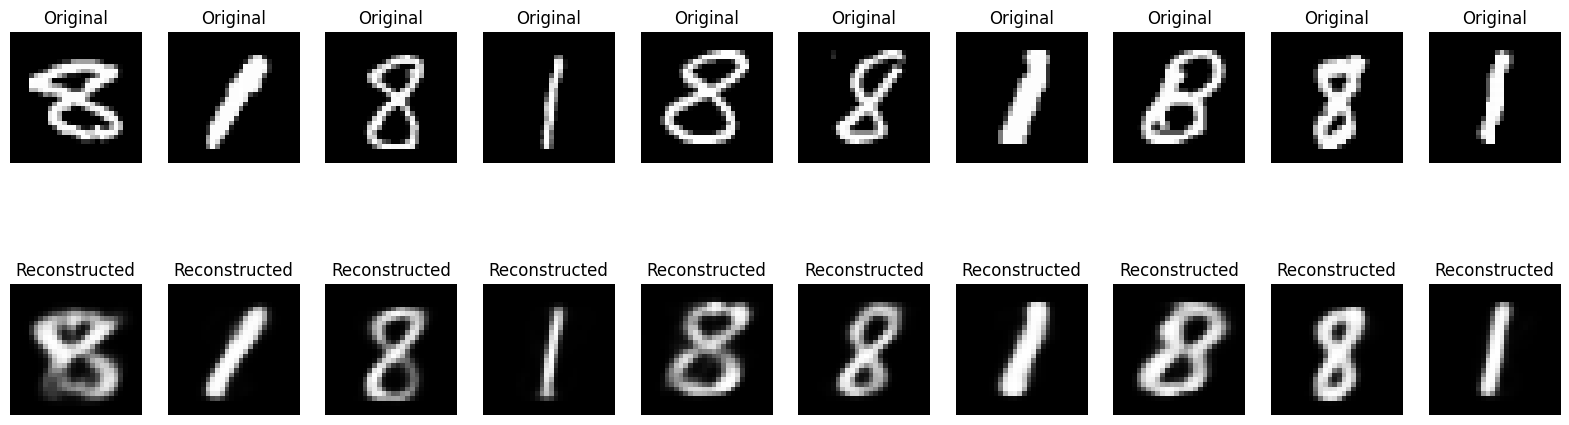

In [ ]:
decoded_imgs = autoencoder.autoencoder.predict(XTest_subset)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Applied PCA to reduce latent space to 3 dimensions.


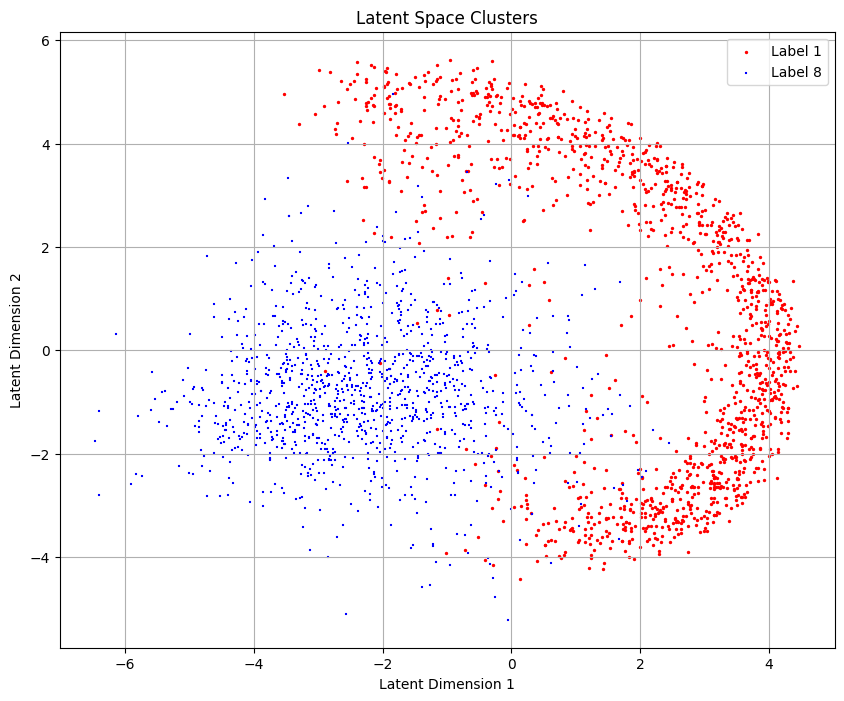

In [117]:
# Plot latent space clusters
autoencoder.plot_clusters(XTest_subset, labels=YTest_subset, apply_pca=True)

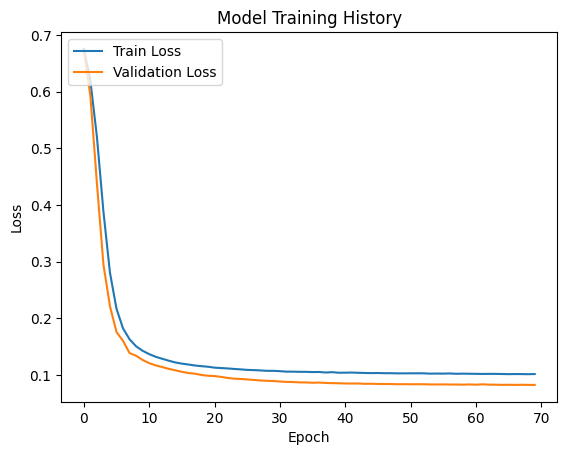

In [118]:
# Plot the training history
autoencoder.plot_model_history()

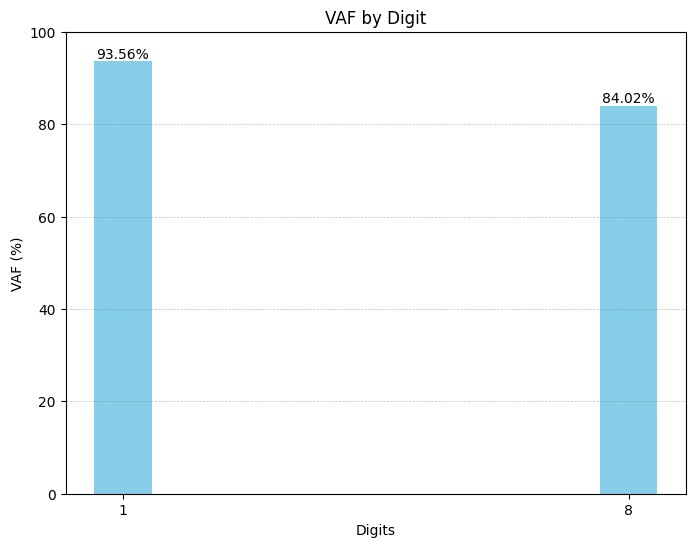

In [119]:
# Compute and plot VAF by class
autoencoder.plot_vaf_by_class(XTest_subset, YTest_subset, decoded_imgs)